# Tennis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
import plotly.express as px
from plotly.subplots import make_subplots as sp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [3]:
df = pd.read_csv('matches.csv')
#fammi il df dei giocatori su winner name, loser name
df_players = pd.concat([df['winner_name'], df['loser_name']])
df_players = df_players.to_frame()
df_players.columns = ['name']
df_players = df_players.drop_duplicates()
df_players = df_players.reset_index(drop=True)
df['tourney_name'] = df['tourney_name'].apply(lambda name: 'Davis Cup' if 'Davis Cup' in name else name)


# 1. Quante partite ha vinto Tsisipas?

In [4]:
# Verifica il nome del giocatore
player_name = "Stefanos Tsitsipas"

# Filtra le partite vinte e perse
matches_won = df[df['winner_name'] == player_name].shape[0]
matches_lost = df[df['loser_name'] == player_name].shape[0]

# Crea il grafico con edge color
fig = go.Figure(data=[
    go.Bar(
        name='Vinte',
        x=['Vinte'],
        y=[matches_won],
        marker=dict(
            color='#d2f644',
            line=dict(color='black', width=2)  # bordo nero
        )
    ),
    go.Bar(
        name='Perse',
        x=['Perse'],
        y=[matches_lost],
        marker=dict(
            color='black',
            line=dict(color='#d2f644', width=2)  # bordo giallo lime
        )
    )
])

# Layout figo
fig.update_layout(
    title=f'Partite vinte e perse da {player_name}',
    xaxis_title='Esito',
    yaxis_title='Numero di partite',
    template='plotly_white'
)

fig.show()

# Fammi il print delle partite vinte e perse
print(f"Partite vinte: {matches_won}")
print(f"Partite perse: {matches_lost}")

Partite vinte: 50
Partite perse: 24


# 2. Qual è l’altezza media dei giocatori nel circuito?

In [5]:
# Crea il DataFrame dei giocatori unici con altezza
players_unique = pd.concat([
    df[['winner_name', 'winner_ht']].rename(columns={'winner_name': 'name', 'winner_ht': 'height'}),
    df[['loser_name', 'loser_ht']].rename(columns={'loser_name': 'name', 'loser_ht': 'height'})
]).drop_duplicates(subset='name').dropna(subset=['height'])

# Filtra nulli e arrotonda le altezze
players_clean = players_unique.copy()
players_clean['height_rounded'] = players_clean['height'].round().astype(int)

# Conta le occorrenze per altezza
height_counts = players_clean['height_rounded'].value_counts().sort_index()
height_df = height_counts[height_counts > 0].reset_index()
height_df.columns = ['height_cm', 'num_players']

# Calcola la media
height_avg = round(players_clean['height'].mean(), 2)

# Crea la figura
fig = go.Figure()

# Istogramma con colore lime e bordo nero
fig.add_trace(go.Bar(
    x=height_df['height_cm'],
    y=height_df['num_players'],
    name='Numero di giocatori',
    marker=dict(
        color='#d2f644',
        line=dict(color='black', width=1.5)
    )
))

# Linea verticale della media
fig.add_trace(go.Scatter(
    x=[height_avg, height_avg],
    y=[0, height_df['num_players'].max()],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name=f"Media: {height_avg} cm"
))

# Linea curva spline che segue le punte
fig.add_trace(go.Scatter(
    x=height_df['height_cm'],
    y=height_df['num_players'],
    mode='lines',
    line=dict(color='black', width=2, shape='spline'),
    name='Curva altezza'
))

# Layout finale tight
fig.update_layout(
    title='Distribuzione delle Altezze dei Giocatori ATP (2023)',
    xaxis=dict(dtick=1),
    xaxis_title='Altezza (cm)',
    yaxis_title='Numero di giocatori',
    height=500,
    width=1000,
    template='plotly_white',
    showlegend=True,
    margin=dict(l=30, r=30, t=50, b=40)
)

fig.show()

#Fammi l'output della media
print(f"Media altezza giocatori: {height_avg} cm")

Media altezza giocatori: 186.07 cm


# 3. Qual è la nazionalità con l’età media più bassa?

In [6]:
# Estrai età e nazione da vincitori e perdenti
winners = df[['winner_name', 'winner_age', 'winner_ioc']].dropna().rename(
    columns={'winner_name': 'player_name', 'winner_age': 'age', 'winner_ioc': 'country'}
)
losers = df[['loser_name', 'loser_age', 'loser_ioc']].dropna().rename(
    columns={'loser_name': 'player_name', 'loser_age': 'age', 'loser_ioc': 'country'}
)
 
# Unisci e rimuovi duplicati per giocatore
players_age_country = pd.concat([winners, losers]).drop_duplicates(subset='player_name')
 
# Calcola età media per nazione
avg_age_by_country = players_age_country.groupby('country')['age'].mean().round(2).sort_values()
top_20_youngest_countries = avg_age_by_country.head(20).reset_index()
 
# Crea il grafico con personalizzazioni per evidenziare differenze
fig = px.bar(
    top_20_youngest_countries,
    x='country',
    y='age',
    title='Età media dei giocatori per nazione (Top 20 più giovani)',
    labels={'country': 'Nazione', 'age': 'Età media'},
    text='age',  # Etichette sui valori
    color='age',  # Colorazione dinamica
    color_continuous_scale='aggrnyl'  # Scala di colore graduale
)
 
# Zoom sull'intervallo delle età presenti (con margine)
min_age = top_20_youngest_countries['age'].min()
max_age = top_20_youngest_countries['age'].max()
fig.update_layout(
    yaxis=dict(range=[min_age - 0.5, max_age + 0.5], tickformat=".2f"),
    xaxis_tickangle=-45
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
 
fig.show()

# Estrai età e nazionalità (codice IOC) di vincitori e perdenti
winners = df[['winner_name', 'winner_age', 'winner_ioc']].dropna().rename(
    columns={'winner_name': 'player_name', 'winner_age': 'age', 'winner_ioc': 'country'}
)
losers = df[['loser_name', 'loser_age', 'loser_ioc']].dropna().rename(
    columns={'loser_name': 'player_name', 'loser_age': 'age', 'loser_ioc': 'country'}
)
 
# Unisci i due set e rimuovi duplicati per giocatore
players_age_country = pd.concat([winners, losers]).drop_duplicates(subset='player_name')
 
# Calcola età media per paese
avg_age_by_country = players_age_country.groupby('country')['age'].mean().round(2).sort_values()
age_map_df = avg_age_by_country.reset_index()
 
# Crea la mappa
fig = px.choropleth(
    age_map_df,
    locations='country',  # Codici IOC (ISO Alpha-3)
    locationmode='ISO-3',
    color='age',
    color_continuous_scale='RdYlGn_r',
    title='Età media dei giocatori per nazione (2023)',
    labels={'age': 'Età media'},
)
 
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False),
    coloraxis_colorbar=dict(title='Età media')
)
 
fig.show()

#Fammi il print dell'età media per nazione
print(avg_age_by_country)


country
VUT    19.90
MAR    20.70
URU    20.95
UZB    21.23
DEN    21.70
       ...  
BLR    29.90
ZIM    30.50
TUN    30.72
MDA    33.20
PAK    34.28
Name: age, Length: 76, dtype: float64


# 4. Qual è la nazionalità con la deviazione standard dell’età media più alta, fra quelle per cui hanno giocato almeno 10 giocatori?
 

In [7]:
# Calcola la deviazione standard dell'età per nazione
winners = df[['winner_name', 'winner_age', 'winner_ioc']].dropna().rename(
    columns={'winner_name': 'player_name', 'winner_age': 'age', 'winner_ioc': 'country'}
)
losers = df[['loser_name', 'loser_age', 'loser_ioc']].dropna().rename(
    columns={'loser_name': 'player_name', 'loser_age': 'age', 'loser_ioc': 'country'}
)
players_age_country = pd.concat([winners, losers]).drop_duplicates(subset='player_name')
std_age_by_country = players_age_country.groupby('country')['age'].std()
 
# Conta il numero di giocatori per nazione
players_per_country = players_age_country['country'].value_counts()
 
# Filtra le nazionalità con almeno 10 giocatori
filtered_countries = std_age_by_country[players_per_country >= 10]
 
# Ordina per deviazione standard decrescente
sorted_std_countries = filtered_countries.sort_values(ascending=False)
 
# Trova la nazionalità con la deviazione standard più alta
country_with_highest_std = sorted_std_countries.idxmax()
highest_std_value = sorted_std_countries.max()
 
# Seleziona le top 10 nazionalità
top_10_std_countries = sorted_std_countries.head(10).reset_index()
top_10_std_countries.columns = ['country', 'std_age']
 
# Crea il grafico
fig = px.bar(
    top_10_std_countries,
    x='country',
    y='std_age',
    title="Top 10 nazionalità per deviazione standard dell'età",
    labels={'country': 'Nazione', 'std_age': 'Deviazione standard'},
    text='std_age',
    color='std_age',
    color_continuous_scale='Aggrnyl'
)
 
fig.update_layout(
    yaxis=dict(title='Deviazione standard'),
    xaxis=dict(title='Nazione', tickangle=-45),
    template='plotly_white'
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.show()

#Fammi il print della deviazione standard dell'età per nazione
print(std_age_by_country)

country
ARG    4.586537
AUS    3.494766
AUT    3.461503
BAR    7.000357
BEL    6.022458
         ...   
USA    4.446019
UZB    3.350124
VIE    2.631223
VUT         NaN
ZIM         NaN
Name: age, Length: 76, dtype: float64


# 5. Quanti giocatori mancini ci sono nel circuito? 

Totale giocatori mancini: 51
Totale destri: 305
Totale sconosciuti: 84


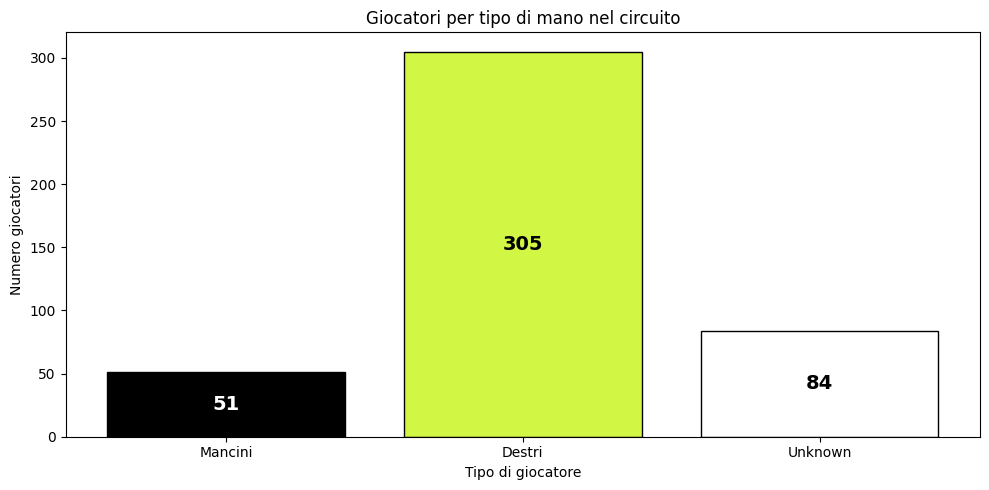

In [25]:
# Estrai tutti i giocatori con la mano
winners = df[['winner_name', 'winner_hand']].rename(columns={'winner_name': 'player_name', 'winner_hand': 'hand'})
losers = df[['loser_name', 'loser_hand']].rename(columns={'loser_name': 'player_name', 'loser_hand': 'hand'})

# Unisci e deduplica
all_players = pd.concat([winners, losers])
all_players = all_players.dropna(subset=['player_name', 'hand'])
all_players = all_players.drop_duplicates(subset='player_name', keep='first')

# Conta le mani
hand_counts = all_players['hand'].value_counts()
left_handed = hand_counts.get('L', 0)
right_handed = hand_counts.get('R', 0)
unknown_handed = hand_counts.get('U', 0)

# Dati per il grafico
labels = ['Mancini', 'Destri', 'Unknown']
values = [left_handed, right_handed, unknown_handed]
colors = ['black', '#d2f644', 'white']

# Stampa console
print(f"Totale giocatori mancini: {left_handed}")
print(f"Totale destri: {right_handed}")
print(f"Totale sconosciuti: {unknown_handed}")

# Grafico
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color=colors, edgecolor='black')

# Numerini al centro delle barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{int(yval)}',
             ha='center', va='center', fontsize=14, fontweight='bold', color='white' if bar.get_facecolor()[:3] == (0, 0, 0) else 'black')

plt.title('Giocatori per tipo di mano nel circuito')
plt.xlabel('Tipo di giocatore')
plt.ylabel('Numero giocatori')
plt.tight_layout()
plt.show()

# 6. Quante partite sono finite con un ritiro? 

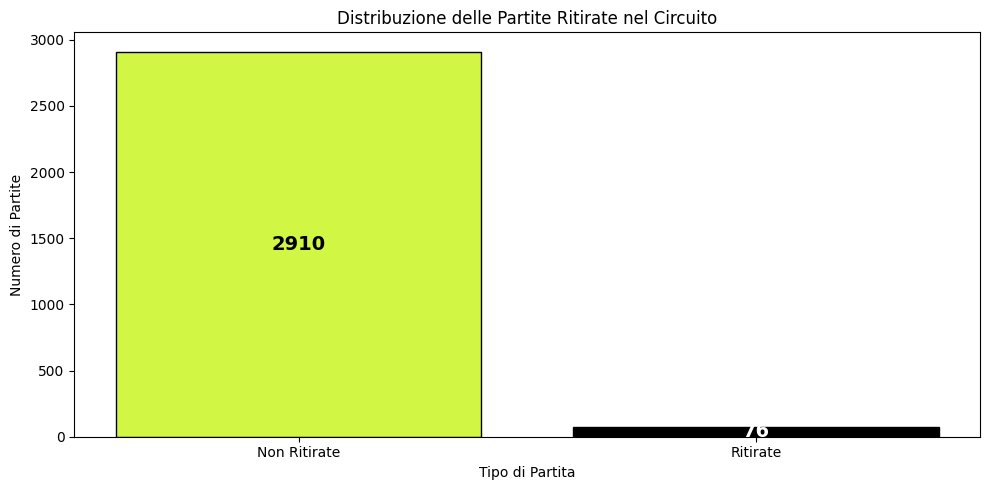

Totale partite: 2986
Partite ritirate: 76


In [27]:


# Conta i match totali e i ritiri
total_matches = df.shape[0]
retired_matches = df[df['score'].str.contains('RET', na=False)].shape[0]
non_retired_matches = total_matches - retired_matches

# Dati per grafico
labels = ['Non Ritirate', 'Ritirate']
values = [non_retired_matches, retired_matches]
colors = ['#d2f644', 'black']

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color=colors, edgecolor='black')

# Numeri centrati dentro le barre
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f'{value}',
        ha='center',
        va='center',
        fontsize=14,
        fontweight='bold',
        color='white' if bar.get_facecolor()[:3] == (0.0, 0.0, 0.0) else 'black'
    )

plt.title('Distribuzione delle Partite Ritirate nel Circuito')
plt.xlabel('Tipo di Partita')
plt.ylabel('Numero di Partite')
plt.tight_layout()
plt.show()

# Stampa a console
print(f"Totale partite: {total_matches}")
print(f"Partite ritirate: {retired_matches}")


# 7. Qual è stato il miglior giocatore sulla terra della stagione in termini di partite vinte?

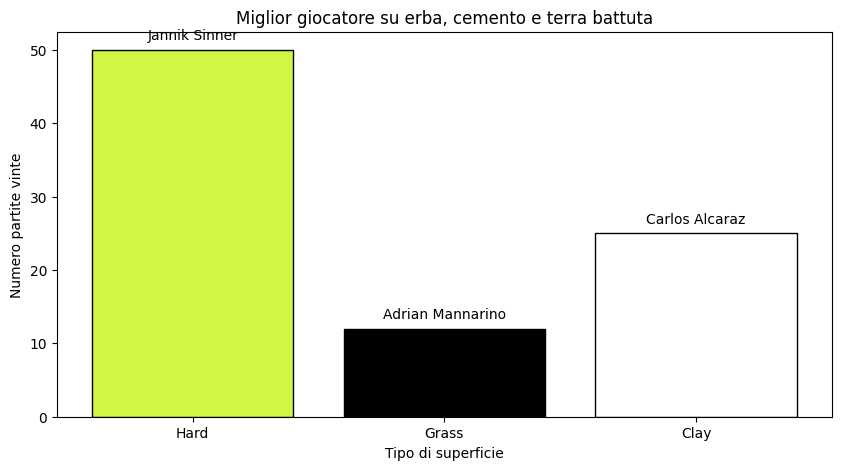

Miglior giocatore su hard: Jannik Sinner
Miglior giocatore su grass: Adrian Mannarino
Miglior giocatore su clay: Carlos Alcaraz


In [10]:
#7) miglior giocatore su hard, grass e clay della stagione in termini di partite vinte

# Filtra il DataFrame per superficie
hard = df[df['surface'] == 'Hard']
grass = df[df['surface'] == 'Grass']
clay = df[df['surface'] == 'Clay']

# Trova il miglior giocatore per ogni superficie
hard_best = hard['winner_name'].value_counts().idxmax()
grass_best = grass['winner_name'].value_counts().idxmax()
clay_best = clay['winner_name'].value_counts().idxmax()

# Conta le vittorie per ogni miglior giocatore
hard_wins = hard[hard['winner_name'] == hard_best].shape[0]
grass_wins = grass[grass['winner_name'] == grass_best].shape[0]
clay_wins = clay[clay['winner_name'] == clay_best].shape[0]

# Crea il grafico
plt.figure(figsize=(10, 5))
bars = plt.bar(['Hard', 'Grass', 'Clay'], [hard_wins, grass_wins, clay_wins], color=['#d2f644', 'black', 'white'], edgecolor='black')

# Aggiungi etichette con i nomi dei giocatori
for bar, surface, best_player in zip(bars, ['Hard', 'Grass', 'Clay'], [hard_best, grass_best, clay_best]):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{best_player}', ha='center', va='bottom', fontsize=10)

# Imposta il titolo e le etichette degli assi
plt.title('Miglior giocatore su erba, cemento e terra battuta')
plt.xlabel('Tipo di superficie')
plt.ylabel('Numero partite vinte')
plt.show()

#Fammi il print di ogni giocatore per superficie
print(f"Miglior giocatore su hard: {hard_best}")
print(f"Miglior giocatore su grass: {grass_best}")
print(f"Miglior giocatore su clay: {clay_best}")

# 8. Qual è stato il torneo con il maggior numero di ace per partita? 


In [11]:
# Calcoliamo gli ace totali per partita sommando quelli del vincitore e del perdente
df['total_aces'] = df['w_ace'].fillna(0) + df['l_ace'].fillna(0)
 
# Calcoliamo il numero medio di ace per partita per ogni torneo
aces_per_match_by_tourney = df.groupby('tourney_name')['total_aces'].mean().sort_values(ascending=False)
 
# Estraiamo la top 10 dei tornei con più ace medi per partita
top_10_aces_per_match = aces_per_match_by_tourney.head(10).reset_index()
top_10_aces_per_match.columns = ['tourney_name', 'avg_aces']
 
# Creiamo il grafico a barre
fig = px.bar(
    top_10_aces_per_match,
    x='tourney_name',
    y='avg_aces',
    title='Top 10 tornei per ace medi a partita (ATP 2023)',
    labels={'tourney_name': 'Torneo', 'avg_aces': 'Ace medi per partita'},
    text='avg_aces',
    color='avg_aces',
    color_continuous_scale='Aggrnyl'
)
 
fig.update_layout(xaxis_tickangle=-45)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
 
fig.show()

#Fammi il print del numero medio di ace per partita per ogni torneo
print(aces_per_match_by_tourney)
 

tourney_name
Wimbledon          20.448819
Stuttgart          20.259259
Dallas             20.037037
Australian Open    19.984252
Tour Finals        18.133333
                     ...    
Umag                5.518519
Buenos Aires        4.962963
Banja Luka          4.851852
Barcelona           4.787234
Davis Cup           4.368182
Name: total_aces, Length: 68, dtype: float64


# 9. Qual è stata la superficie con il minor numero di set per partita?


In [12]:

# Conta i set: ogni "-" rappresenta un set
df['num_sets'] = df['score'].apply(lambda x: str(x).count('-'))

# Rimuove righe senza superficie o punteggio valido
df_clean = df.dropna(subset=['surface', 'score'])

# Totale set giocati per superficie
surface_set_counts = df_clean.groupby('surface')['num_sets'].sum().reset_index()

# Ordine richiesto: nero (Clay), lime (Hard), bianco (Grass)
surface_order = ['Clay', 'Hard', 'Grass']
palette = ['#000000', '#d2f644', '#ffffff']

# Filtro e ordina le superfici
surface_set_counts = surface_set_counts[surface_set_counts['surface'].isin(surface_order)]
surface_set_counts = surface_set_counts.set_index('surface').loc[surface_order].reset_index()

# Crea la figura
fig = go.Figure()

for i, row in surface_set_counts.iterrows():
    color = palette[i]
    text_color = 'white' if color == '#000000' else 'black'
    
    fig.add_trace(go.Bar(
        x=[row['surface']],
        y=[row['num_sets']],
        marker=dict(
            color=color,
            line=dict(color='black', width=1.5)
        ),
        name=row['surface'],
        text=f"{row['num_sets']}",
        textposition='inside',
        insidetextanchor='middle',
        textfont=dict(color=text_color)
    ))

# Layout finale
fig.update_layout(
    title='Totale Set Giocati per Superficie',
    xaxis_title='Superficie',
    yaxis_title='Numero di Set Giocati',
    template='plotly_white',
    height=500,
    width=800,
    margin=dict(l=30, r=30, t=50, b=40),
    showlegend=False
)

fig.show()

# Fammi l'output della superficie meno giocata
least_played_surface = surface_set_counts['surface'].iloc[surface_set_counts['num_sets'].idxmin()]
print(f"Superficie meno giocata: {least_played_surface}")



Superficie meno giocata: Grass


# 10.Quanti set ha vinto Berrettini sull’erba?

In [13]:
# Funzione per contare i set vinti da un giocatore (in qualsiasi match)
def count_sets_won_general(row):
    sets_won = 0
    score_str = str(row['score'])
    is_winner = row['winner_name'] == 'Matteo Berrettini'
    for s in score_str.split():
        if '-' in s:
            try:
                p1, p2 = map(int, s.split('-')[:2])
                if (is_winner and p1 > p2) or (not is_winner and p2 > p1):
                    sets_won += 1
            except:
                continue
    return sets_won

# Filtra tutte le partite giocate da Berrettini
berrettini_matches = df[
    (df['winner_name'] == 'Matteo Berrettini') | (df['loser_name'] == 'Matteo Berrettini')
].copy()

# Calcola i set vinti in ogni partita (indipendentemente dall'esito)
berrettini_matches['sets_won'] = berrettini_matches.apply(count_sets_won_general, axis=1)

# Raggruppa per superficie
sets_won_all_matches = berrettini_matches.groupby('surface')['sets_won'].sum().sort_values(ascending=False)

# Pie chart
import plotly.express as px

fig = px.pie(
    names=sets_won_all_matches.index,
    values=sets_won_all_matches.values,
    title="Set vinti da Matteo Berrettini per superficie (in tutte le partite)",
    hole=0.4,
    color=sets_won_all_matches.index,
    color_discrete_sequence=px.colors.sequential.Aggrnyl[::-1]
)

fig.update_traces(textinfo='value+label')

fig.update_layout(
    legend=dict(
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="left",
        x=1.05
    )
)

fig.show()

# Stampa i set vinti su erba (anche da partite perse)
print(f"Set vinti da Berrettini su erba (tutte le partite): {sets_won_all_matches.get('Grass', 0)}")


Set vinti da Berrettini su erba (tutte le partite): 7


# 11. Esiste una relazione fra numero di set vinti e ranking?

In [14]:
 
df_filtered = df.dropna(subset=['winner_rank', 'num_sets'])
 
# Raggruppa per vincitore e calcola il totale dei set vinti
sets_won_by_player = df_filtered.groupby('winner_name')['num_sets'].sum().reset_index()
sets_won_by_player.columns = ['player_name', 'total_sets_won']
 
# Aggiungi il ranking dei vincitori
ranking_by_player = df_filtered[['winner_name', 'winner_rank']].drop_duplicates().rename(
    columns={'winner_name': 'player_name', 'winner_rank': 'rank'}
)
 
# Unisci i dati
sets_vs_rank = pd.merge(sets_won_by_player, ranking_by_player, on='player_name')
 
# Calcola il coefficiente di correlazione
correlation = sets_vs_rank['total_sets_won'].corr(sets_vs_rank['rank'])
 
# Crea il grafico a dispersione
fig = px.scatter(
    sets_vs_rank,
    x='rank',
    y='total_sets_won',
    title=f'Relazione fra numero di set vinti e ranking (Correlazione: {correlation:.2f})',
    labels={'rank': 'Ranking', 'total_sets_won': 'Set vinti'},
    hover_data=['player_name']
)
 
fig.update_traces(marker=dict(size=8, color='#d2f644', line=dict(width=1, color='black')))
fig.update_layout(template='plotly_white')
 
fig.show()

# Fammi il print della correlazione
print(f"Correlazione fra set vinti e ranking: {correlation:.2f}")

Correlazione fra set vinti e ranking: -0.49


# 12.Qual è il rapporto fra set vinti e persi di Sinner per ciascun trimestre


In [15]:
# Funzione per contare i set vinti da un giocatore
def count_sets(score_str, is_winner):
    sets_won = 0
    try:
        sets = str(score_str).split()
        for s in sets:
            if '-' in s:
                parts = s.split('-')
                if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
                    p1, p2 = int(parts[0]), int(parts[1])
                    if (p1 > p2 and is_winner) or (p2 > p1 and not is_winner):
                        sets_won += 1
    except:
        pass
    return sets_won

# Applichiamo la funzione a tutte le partite
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
df['sets_won'] = df.apply(
    lambda row: count_sets(row['score'], is_winner=(row['winner_name'] == 'Jannik Sinner'))
    if 'Jannik Sinner' in [row['winner_name'], row['loser_name']] else 0,
    axis=1
)
df['sets_lost'] = df.apply(
    lambda row: count_sets(row['score'], is_winner=(row['loser_name'] == 'Jannik Sinner'))
    if 'Jannik Sinner' in [row['winner_name'], row['loser_name']] else 0,
    axis=1
)

# Filtra le partite di Sinner
sinner_matches = df[(df['winner_name'] == 'Jannik Sinner') | (df['loser_name'] == 'Jannik Sinner')]

# Raggruppa per trimestre
sinner_sets = sinner_matches.resample('QE', on='tourney_date')[['sets_won', 'sets_lost']].sum()

# Calcola il rapporto
sinner_sets['Rapporto set vinti/persi'] = sinner_sets['sets_won'] / sinner_sets['sets_lost']
sinner_ratio = sinner_sets.reset_index()

# Visualizza il grafico
fig = px.bar(
    sinner_ratio,
    x='tourney_date',
    y='Rapporto set vinti/persi',
    title="Rapporto fra set vinti e persi da Sinner per trimestre",
    labels={'tourney_date': 'Trimestre', 'Rapporto set vinti/persi': 'Rapporto Set Vinti/Persi'},
    color='Rapporto set vinti/persi',
    color_continuous_scale='Aggrnyl'
)

fig.update_layout(template='plotly_white')
fig.show()

#Fammi il print del rapporto set vinti/persi
print(sinner_sets)


              sets_won  sets_lost  Rapporto set vinti/persi
tourney_date                                               
2023-03-31          43         14                  3.071429
2023-06-30          24         12                  2.000000
2023-09-30          40         11                  3.636364
2023-12-31          25          7                  3.571429


# 13. Esiste un rapporto fra altezza e probabilità di ace? Come cambia questo rapporto in funzione della superficie?

In [16]:
# Calcoliamo gli ace totali per partita sommando quelli del vincitore e del perdente
winners = df[['winner_name', 'w_ace', 'winner_ht', 'surface']].dropna()
losers = df[['loser_name', 'l_ace', 'loser_ht', 'surface']].dropna()
 
winners.columns = ['player_name', 'aces', 'height', 'surface']
losers.columns = ['player_name', 'aces', 'height', 'surface']
 
ace_data = pd.concat([winners, losers], ignore_index=True)
 
# Altezza vs ace medi globali
player_ace_stats = ace_data.groupby('player_name').agg({
    'aces': 'mean',
    'height': 'first'
}).reset_index()
 
correlation = player_ace_stats['height'].corr(player_ace_stats['aces'])
 
X = sm.add_constant(player_ace_stats['height'])
model = sm.OLS(player_ace_stats['aces'], X).fit()
player_ace_stats['predicted_aces'] = model.predict(X)
 
# Altezza vs ace per superficie
avg_aces_by_height_surface = ace_data.groupby(['height', 'surface'])['aces'].mean().reset_index()
 
# Calcolo regressione e correlazione per ogni superficie
regression_results = {}
for surface in avg_aces_by_height_surface['surface'].unique():
    data = avg_aces_by_height_surface[avg_aces_by_height_surface['surface'] == surface].copy()
    X = sm.add_constant(data['height'])
    model = sm.OLS(data['aces'], X).fit()
    data['predicted_aces'] = model.predict(X)
    regression_results[surface] = {
        'data': data,
        'correlation': data['height'].corr(data['aces'])
    }
 

# Crea il grafico combinato
fig = sp(
    rows=1, cols=2,
    subplot_titles=[
        f"Altezza vs Ace Medi (correlazione: {correlation:.2f})",
        "Altezza vs Ace Medi per Superficie"
    ],
    horizontal_spacing=0.12
)
 
# Grafico globale
fig.add_trace(go.Scatter(
    x=player_ace_stats['height'],
    y=player_ace_stats['aces'],
    mode='markers',
    name='Dati reali (globale)',
    marker=dict(color='yellowgreen', size=8, line=dict(color='black', width=1), opacity=0.6)
), row=1, col=1)
 
fig.add_trace(go.Scatter(
    x=player_ace_stats['height'],
    y=player_ace_stats['predicted_aces'],
    mode='lines',
    name='Regressione (globale)',
    line=dict(color='firebrick', width=3)
), row=1, col=1)
 
# Colori superficie
colors = {'Hard': 'gainsboro', 'Clay': 'black', 'Grass': 'yellowgreen'}
 
# Grafico per superficie
for surface, result in regression_results.items():
    data = result['data']
    corr = result['correlation']
 
    fig.add_trace(go.Scatter(
        x=data['height'],
        y=data['aces'],
        mode='markers',
        name=f'{surface} (corr: {corr:.2f})',
        marker=dict(color=colors.get(surface, 'gray'), size=8, line=dict(color='black', width=1))
    ), row=1, col=2)
 
    fig.add_trace(go.Scatter(
        x=data['height'],
        y=data['predicted_aces'],
        mode='lines',
        name=f'Regressione {surface}',
        line=dict(color=colors.get(surface, 'gray'), dash='dash')
    ), row=1, col=2)
 
# Layout finale
fig.update_layout(
    title="Relazione tra Altezza e Ace Medi - Globale e per Superficie",
    xaxis_title='Altezza (cm)',
    yaxis_title='Ace medi per partita',
    xaxis2_title='Altezza (cm)',
    yaxis2_title='Ace medi per partita',
    template='plotly_white'
)
 
fig.show()

# 14.Come cambia la distribuzione del numero di break point subiti e salvati per un giocatore perdente o vincente?

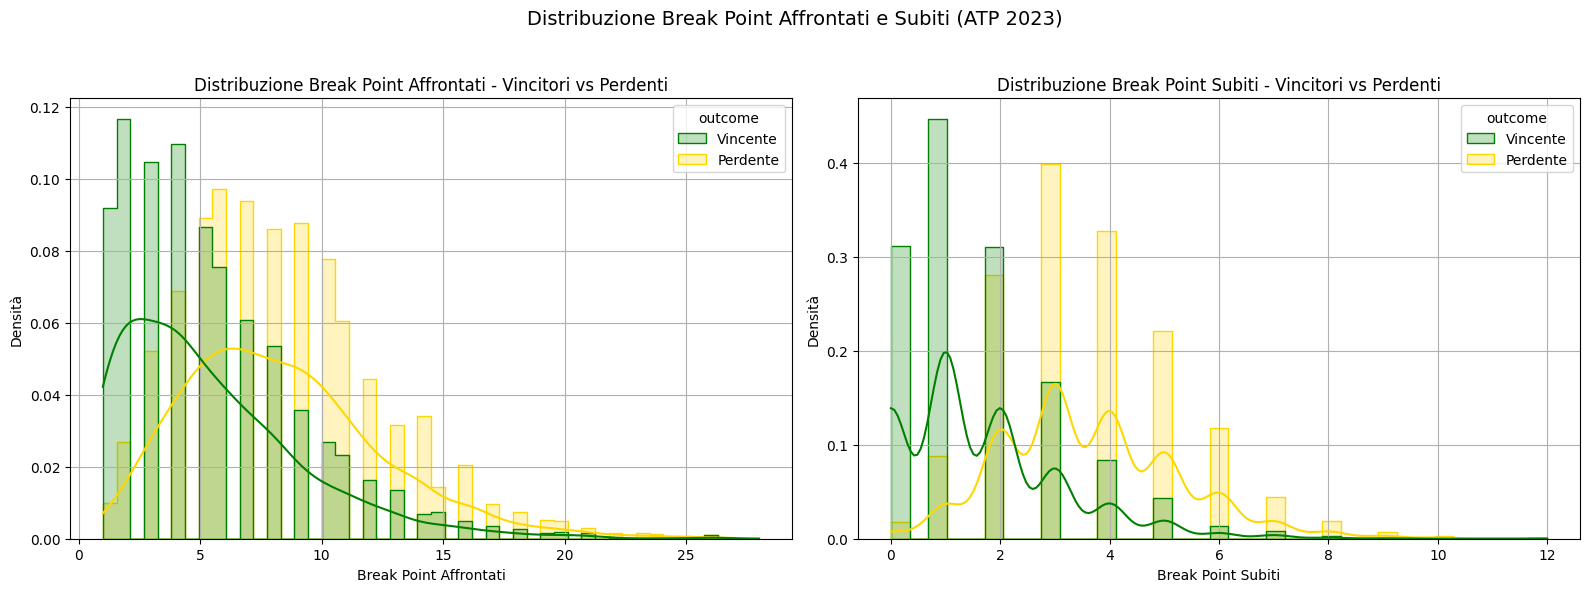

In [17]:
# Selezioniamo solo le colonne necessarie per vincitori e perdenti
bp_data = df[['winner_name', 'w_bpFaced', 'w_bpSaved', 'loser_name', 'l_bpFaced', 'l_bpSaved']]
 
# Riorganizziamo i dati in un formato unificato: una riga per ciascun giocatore per match
winners = bp_data[['winner_name', 'w_bpFaced', 'w_bpSaved']].copy()
winners.columns = ['player_name', 'bp_faced', 'bp_saved']
winners['outcome'] = 'Vincente'
 
losers = bp_data[['loser_name', 'l_bpFaced', 'l_bpSaved']].copy()
losers.columns = ['player_name', 'bp_faced', 'bp_saved']
losers['outcome'] = 'Perdente'
 
# Uniamo i due dataset
bp_combined = pd.concat([winners, losers], ignore_index=True).dropna()
 
# Calcoliamo i break point subiti (non salvati)
bp_combined['bp_conceded'] = bp_combined['bp_faced'] - bp_combined['bp_saved']
 
# Creiamo un nuovo campo: percentuale di break point salvati (evitiamo divisioni per 0)
bp_combined = bp_combined[bp_combined['bp_faced'] > 0]  # consideriamo solo i match dove si sono affrontati bp
bp_combined['bp_saved_pct'] = bp_combined['bp_saved'] / bp_combined['bp_faced']
 
# Ricoloreiamo il grafico con colori personalizzati: verde per vincitori, giallo per perdenti
custom_palette = {'Vincente': 'green', 'Perdente': 'gold'}
 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
 
# Distribuzione: Break Point Affrontati
sns.histplot(
    data=bp_combined,
    x='bp_faced',
    hue='outcome',
    kde=True,
    element='step',
    stat='density',
    palette=custom_palette,
    ax=axes[0]
)
axes[0].set_title('Distribuzione Break Point Affrontati - Vincitori vs Perdenti')
axes[0].set_xlabel('Break Point Affrontati')
axes[0].set_ylabel('Densità')
axes[0].grid(True)
 
# Distribuzione: Break Point Subiti (non salvati)
sns.histplot(
    data=bp_combined,
    x='bp_conceded',
    hue='outcome',
    kde=True,
    element='step',
    stat='density',
    palette=custom_palette,
    ax=axes[1]
)
axes[1].set_title('Distribuzione Break Point Subiti - Vincitori vs Perdenti')
axes[1].set_xlabel('Break Point Subiti')
axes[1].set_ylabel('Densità')
axes[1].grid(True)
 
plt.suptitle('Distribuzione Break Point Affrontati e Subiti (ATP 2023)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 15.Come cambia la distribuzione delle durate del tempo delle partite con la differenza di ranking dei giocatori?

In [18]:
# Calcola la differenza di ranking tra vincitore e perdente
df['rank_diff'] = abs(df['winner_rank'] - df['loser_rank'])
 
# Filtra le righe con valori validi per 'minutes' e 'rank_diff'
df_filtered = df.dropna(subset=['minutes', 'rank_diff'])
 
# Crea un boxplot per mostrare la distribuzione delle durate delle partite in base alla differenza di ranking
fig = px.box(
    df_filtered,
    x=pd.cut(df_filtered['rank_diff'], bins=[0, 10, 50, 100, 200, 500, 1000], labels=['0-10', '11-50', '51-100', '101-200', '201-500', '501+']),
    y='minutes',
    title='Distribuzione delle durate delle partite in base alla differenza di ranking',
    labels={'x': 'Differenza di Ranking', 'minutes': 'Durata (minuti)'},
    color_discrete_sequence=['#d2f644']
)
 
fig.update_layout(template='plotly_white')
fig.update_xaxes(categoryorder='array', categoryarray=['0-10', '11-50', '51-100', '101-200', '201-500', '501+'])
fig.show()

# 16.Quanto frequentemente un giocatore con un ranking minore sconfigge uno con un ranking maggiore?

In [29]:
# Filtra gli upset
upsets = df[df['winner_rank'] > df['loser_rank']]
total_matches = len(df)
upset_frequency = len(upsets) / total_matches

# Prepara i dati
upset_data = pd.DataFrame({
    'Categoria': ['Upset', 'Non-Upset'],
    'Frequenza': [len(upsets), total_matches - len(upsets)]
})

# Grafico con numeri DENTRO le colonne
fig = px.bar(
    upset_data,
    x='Categoria',
    y='Frequenza',
    text='Frequenza',
    title=f"Frequenza di upset (giocatore con ranking minore che vince): {upset_frequency:.2%}",
    color='Categoria',
    color_discrete_sequence=['#000000', '#d2f644']
)

# Etichette centrali e font leggibile
fig.update_traces(
    textposition='inside',
    textfont_size=14,
    textfont_color='white',
    insidetextanchor='middle'
)

fig.update_layout(template='plotly_white')
fig.show()

# 17.Quanto frequentemente un giocatore fuori dalla top 100 sconfigge un giocatore in top 10?

#  

In [20]:
# Convertiamo le colonne di ranking a numeri interi, ignorando i valori nulli
df['winner_rank'] = pd.to_numeric(df['winner_rank'], errors='coerce')
df['loser_rank'] = pd.to_numeric(df['loser_rank'], errors='coerce')
 
# Rimuoviamo i match senza ranking
ranked_matches = df.dropna(subset=['winner_rank', 'loser_rank'])
 
# Definiamo una funzione per calcolare la frequenza di upset fuori top 100 vs soglia top X
def count_upsets(threshold):
    condition = (ranked_matches['winner_rank'] > 100) & (ranked_matches['loser_rank'] <= threshold)
    total = ranked_matches[ranked_matches['loser_rank'] <= threshold].shape[0]
    upsets = condition.sum()
    return upsets, total, upsets / total if total > 0 else 0
 
# Calcolo per Top 10, 20, 50, 100
upset_stats = {
    'Top 10': count_upsets(10),
    'Top 20': count_upsets(20),
    'Top 50': count_upsets(50),
    'Top 100': count_upsets(100)
}
 
# Prepara i dati per il grafico
upset_df = pd.DataFrame([
    {'Soglia': key, 'Frequenza': val[2] * 100} for key, val in upset_stats.items()
])
 
# Ordina le soglie per Top 10, 20, 50, 100
upset_df['Soglia'] = pd.Categorical(upset_df['Soglia'], categories=['Top 10', 'Top 20', 'Top 50', 'Top 100'], ordered=True)
upset_df = upset_df.sort_values('Soglia')
 
# Crea il grafico a barre
fig = px.bar(
    upset_df,
    x='Soglia',
    y='Frequenza',
    text='Frequenza',
    title='Frequenza di vittorie da parte di giocatori fuori dalla Top 100 contro Top X',
    labels={'Frequenza': 'Frequenza (%)'},
    color='Soglia',
    color_discrete_sequence=px.colors.sequential.Aggrnyl[::-1]
)
 
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(yaxis_range=[0, 20], template='plotly_white', showlegend=False)
 
fig.show()
 

# 18. Esiste una correlazione fra il numero di ace effettuati dai due giocatori?

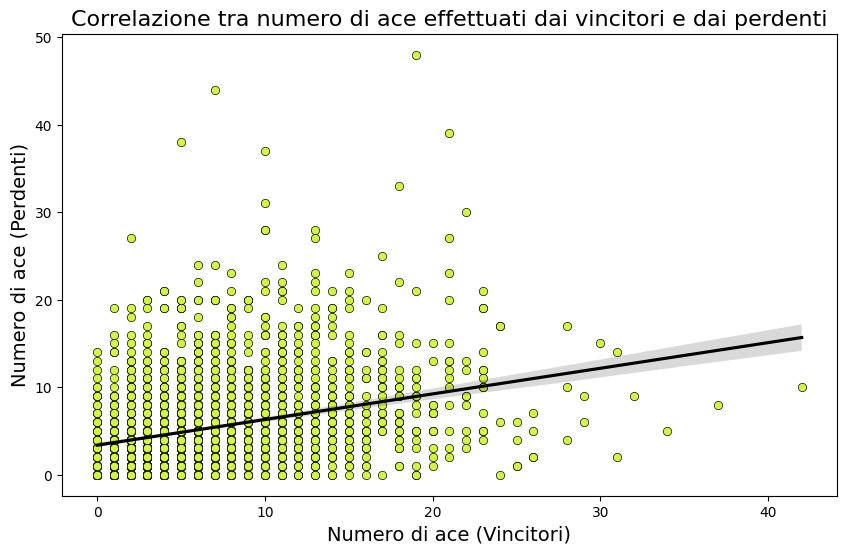

Correlazione tra numero di ace dei vincitori e dei perdenti: 0.30


In [21]:
# Creare il grafico a dispersione (scatter plot)
plt.figure(figsize=(10, 6))
 
# Creiamo il grafico a dispersione tra ace dei vincitori e dei perdenti
sns.scatterplot(x=df['w_ace'], y=df['l_ace'], color='#d2f644', edgecolor='black')
 
# Aggiungere una linea di regressione per mostrare la correlazione
sns.regplot(x=df['w_ace'], y=df['l_ace'], scatter=False, color='black')
 
# Aggiungere il titolo e le etichette
plt.title('Correlazione tra numero di ace effettuati dai vincitori e dai perdenti', fontsize=16)
plt.xlabel('Numero di ace (Vincitori)', fontsize=14)
plt.ylabel('Numero di ace (Perdenti)', fontsize=14)
 
# Mostrare il grafico
plt.show()
 
correlation = df['w_ace'].corr(df['l_ace'])
print(f"Correlazione tra numero di ace dei vincitori e dei perdenti: {correlation:.2f}")

# 19. Qual è la distribuzione del ranking di una wild card in un APT 500?

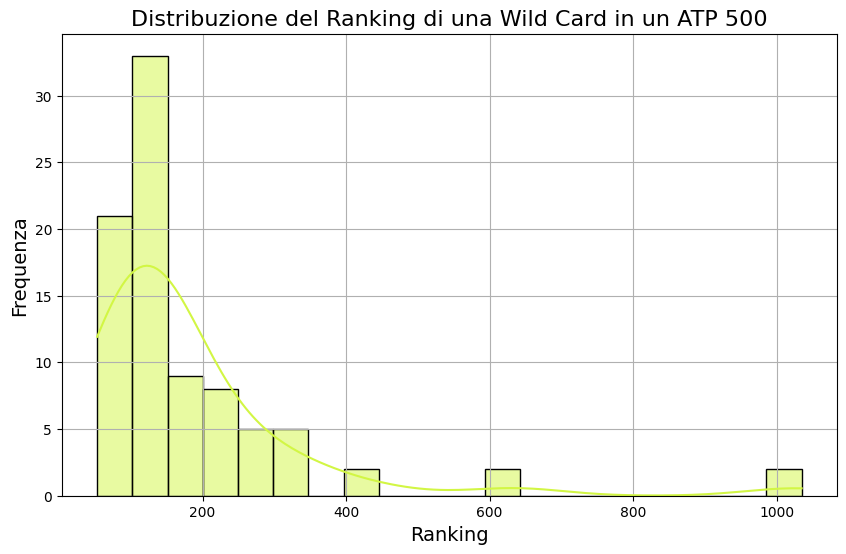

In [22]:
# Filtra i dati per i tornei di livello ATP 500 e per i giocatori con entry 'WC' (wild card)
wild_card_data = df[(df['tourney_level'] == 'A') & (df['winner_entry'] == 'WC')]
 
# Estrai i ranking dei vincitori wild card
wild_card_ranking = wild_card_data['winner_rank'].dropna()
 
# Crea un grafico per mostrare la distribuzione del ranking
plt.figure(figsize=(10, 6))
sns.histplot(wild_card_ranking, bins=20, kde=True, color='#d2f644', edgecolor='black')
plt.title('Distribuzione del Ranking di una Wild Card in un ATP 500', fontsize=16)
plt.xlabel('Ranking', fontsize=14)
plt.ylabel('Frequenza', fontsize=14)
plt.grid(True)
plt.show()

# 20.Come posso stimare la probabilità di vittoria fra due giocatori in base al loro ranking? E qual è l’errore medio di questa stima?

In [32]:
# Pulizia e preparazione
df_clean = df[['winner_rank', 'loser_rank']].dropna()
df_clean = df_clean[(df_clean['winner_rank'] > 0) & (df_clean['loser_rank'] > 0)]
df_clean['rank_diff'] = df_clean['loser_rank'] - df_clean['winner_rank']

# Rimuovi outlier estremi
filtered_df = df_clean[(df_clean['rank_diff'] >= -150) & (df_clean['rank_diff'] <= 150)].copy()
filtered_df['label'] = 1

# Crea versione invertita
reverse_df = filtered_df.copy()
reverse_df['rank_diff'] = -reverse_df['rank_diff']
reverse_df['label'] = 0

# Unisci dataset
full_df = pd.concat([filtered_df, reverse_df])

# Fit modello logistico
X = full_df[['rank_diff']]
y = full_df['label']
model = LogisticRegression()
model.fit(X, y)
full_df['predicted_prob'] = model.predict_proba(X)[:, 1]

# Calcola win rate osservata per bin
bin_width = 5
full_df['rank_diff_bin'] = (full_df['rank_diff'] // bin_width) * bin_width
true_win_rate = full_df.groupby('rank_diff_bin')['label'].mean().reset_index()
true_win_rate.columns = ['rank_diff', 'true_win_rate']

# Media predizioni per rank_diff
plot_df = full_df.groupby('rank_diff')['predicted_prob'].mean().reset_index()
plot_df = plot_df.merge(true_win_rate, on='rank_diff', how='left')

# Grafico in stile Bellora™
fig = px.line(
    plot_df,
    x='rank_diff',
    y=['predicted_prob', 'true_win_rate'],
    labels={
        'value': 'Probabilità di vittoria',
        'rank_diff': 'Differenza di ranking (avversario - giocatore)'
    },
    title='Probabilità di vittoria stimata vs osservata (con outlier rimossi)',
    color_discrete_map={
        'predicted_prob': '#d2f644',  # lime
        'true_win_rate': '#000000'   # nero
    }
)

fig.update_traces(mode='lines+markers')
fig.update_layout(template='plotly_white', legend_title_text='Tipo di stima')
fig.show()